In [1]:
#Data preparation

In [2]:
import pandas as pd
#load wiki data with summary for KC
kc_wiki_with_summary = pd.read_csv('../../data/data_wiki_clustering/kc_wiki_with_summary.csv')
import pandas as pd
#load wiki data with summary for KC
kc_wiki_with_summary = pd.read_csv('../../data/data_wiki_clustering/kc_wiki_with_summary.csv')
#pre-process data
#reference for gensim library https://www.kaggle.com/code/venkatkrishnan/gensim-text-mining-techniques
#https://radimrehurek.com/gensim/parsing/preprocessing.html
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, strip_punctuation, remove_stopwords, strip_short
transform_to_lower = lambda s: s.lower()
filters = [strip_tags,
          transform_to_lower,
          strip_punctuation,
          strip_multiple_whitespaces,
          remove_stopwords,
          strip_short
          ]

def cleaning_text(text):
    clean_text = preprocess_string(text, filters)
    return clean_text

kc_wiki_with_summary['clean_summary'] = kc_wiki_with_summary['page_summary'].apply(cleaning_text)
import geopandas as gpd
kc_wiki_with_summary = gpd.GeoDataFrame(kc_wiki_with_summary, geometry = gpd.points_from_xy(kc_wiki_with_summary.gt_lon,
                                                                                                   kc_wiki_with_summary.gt_lat),
                                           crs="EPSG:4326").to_crs("EPSG:27700")

In [3]:
import numpy as np
kc_wiki_with_summary['easting'] = kc_wiki_with_summary['geometry'].x
kc_wiki_with_summary['northing'] = kc_wiki_with_summary['geometry'].y
kc_coords = kc_wiki_with_summary[['easting', 'northing']].to_numpy()
#kc_coords

In [ ]:
#DBSCAN clustering

C:\Users\smn18\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


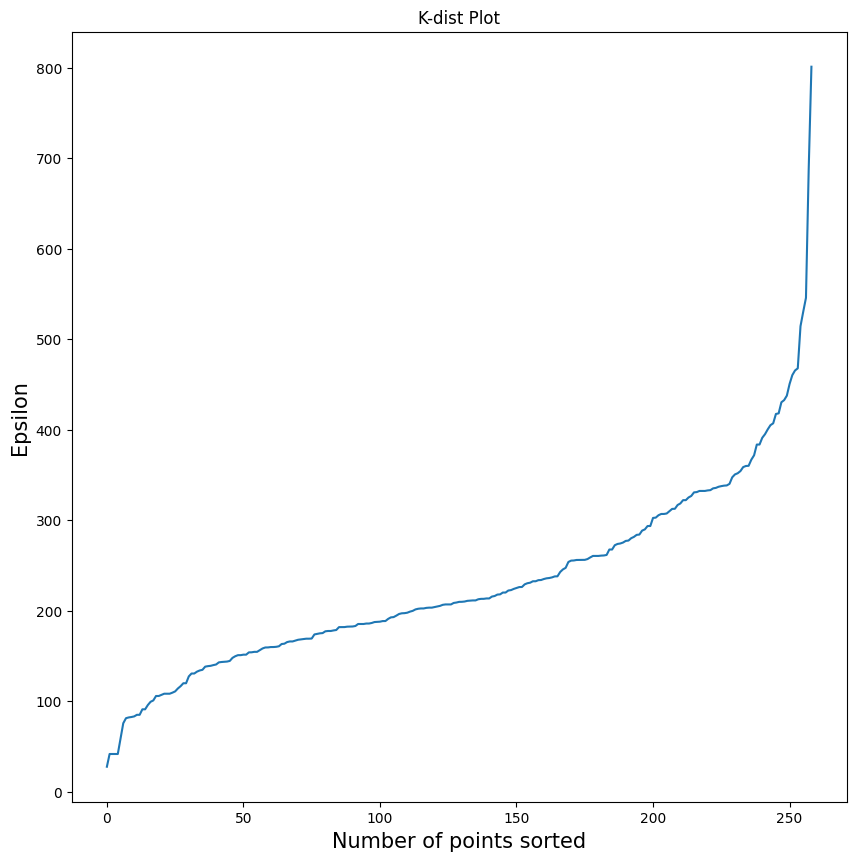

In [4]:
#finding the optimum epsilon
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
#Codes inspired from Medium post by Tara Mullin (2020), titled : DBSCAN Parameter Estimation Using Python
#Available at: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,4]
#plot data
plt.figure(figsize=(10, 10))
plt.title('K-dist Plot')
plt.xlabel('Number of points sorted', fontsize=15)
plt.ylabel('Epsilon',fontsize=15)
plt.plot(distances)

In [5]:
#run dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=200, min_samples=5, metric='euclidean') 
db = dbscan.fit(kc_coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
num_noise = list(cluster_labels).count(-1)
print(num_clusters)
print(num_noise)

16
95


[<POLYGON ((527917.541 178457.123, 527774.985 178606.986, 527999.392 178793.0...>, <POLYGON ((525709.446 179359.01, 525460.494 179534.606, 525525.029 179797.98...>, <POLYGON ((527136.424 178053.646, 526834.839 178140.7, 526605.696 178290.106...>, <POLYGON ((525222.193 180437.452, 525080.67 180545.239, 525250.471 180620.51...>, <POLYGON ((526343.288 178617.139, 526155.118 178657.904, 526026.859 178788.2...>, <POLYGON ((526573.211 177766.983, 526509.341 177821.031, 526451.31 177919.73...>, <POLYGON ((527430.882 178997.269, 527332.022 179208.994, 527474.281 179236.0...>, <POLYGON ((527272.543 178785.445, 526871.989 178990.639, 526683.559 179224.9...>, <POLYGON ((527789.54 178974.42, 527688.096 179018.854, 527897.354 179443.863...>, <POLYGON ((526857.864 177495.891, 526848.626 177618.68, 526846.761 177662.52...>, <POLYGON ((527461.812 177710.165, 527493.092 177931.27, 527851.395 178048.69...>, <POLYGON ((527206.943 178539.448, 527031.172 178577.709, 526891.008 178642.8...>, <POLYGON ((5244

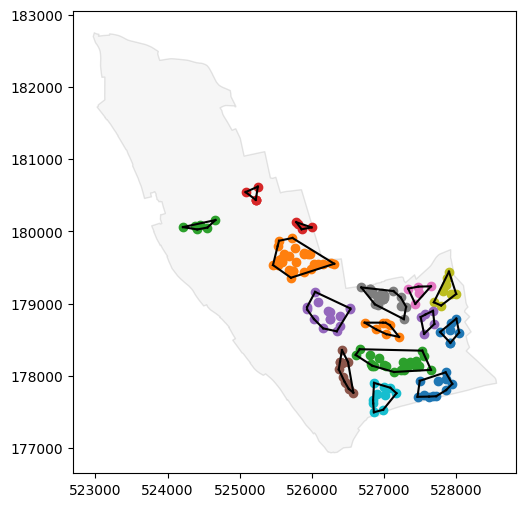

In [6]:
#Regionalise
#create convex hull
#Reference: The Scipy Community, Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#remove noise
kc_wiki_with_summary['cluster'] = cluster_labels
remove = kc_wiki_with_summary[kc_wiki_with_summary['cluster'] == -1].index
kc_wiki_with_summary = kc_wiki_with_summary.drop(remove)
#select only necessary column
db_cl = kc_wiki_with_summary[["easting",
                   "northing",
                   "cluster"]]

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
import geopandas as gpd
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=27700).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
for i in range(0,15):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["easting", "northing"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#plt.savefig('../../docs/docs_wiki_clustering/dbscan_wiki_kc_reg.png')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)


In [12]:
#Create sequence of data

In [9]:
#group wikipedia summary by cluster
from itertools import chain
kc_wiki_with_summary = kc_wiki_with_summary.groupby('cluster', as_index = False)['clean_summary'].agg(lambda x: list(chain.from_iterable(x)))
data_dbscan = pd.DataFrame(kc_wiki_with_summary, columns =('cluster', 'clean_summary'))
tag_list_dbscan = data_dbscan.clean_summary.values.tolist()

In [11]:
data_dbscan.to_csv('../../docs/docs_agile/kc_wiki_dbscan_tag.csv')

In [10]:
#for llm
kc_wiki_with_summary_dbscan = kc_wiki_with_summary.groupby('cluster')['page_summary'].apply(list)
data_dbscan_llm = pd.DataFrame(kc_wiki_with_summary_dbscan, columns =('cluster', 'page_summary'))
data_dbscan_llm['geometry'] = c_h
data_dbscan_llm.to_csv('../../data/data_wiki_clustering/kc_wiki_dbscan_tag_llm_4.csv')


In [11]:
data_dbscan_llm.to_csv('../../docs/docs_agile/kc_wiki_dbscan_tag_llm.csv')

In [ ]:
#RUN LDA

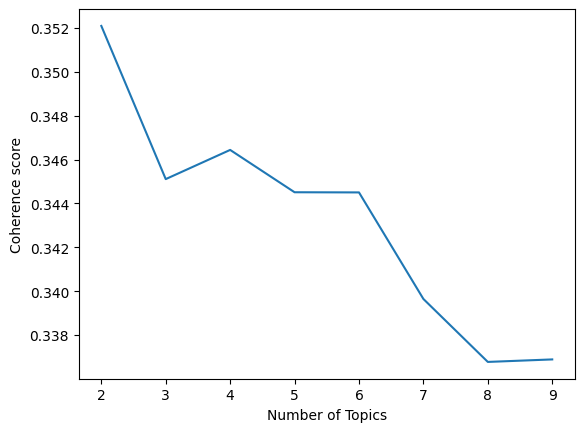

In [13]:
#calculate coherence value for differenct topic number
#Code inspired from Medium post by Aravind CR (2020), titled, Topic Modelling using Gensim-LDA in Python
#Available at: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
#https://radimrehurek.com/gensim/models/ldamodel.html
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
# Create a corpus from a list of texts
dictionary = Dictionary(tag_list_dbscan)
corpus = [dictionary.doc2bow(text) for text in tag_list_dbscan]
coherence_values = []
def coherence_value(dictionary, texts, corpus, start, stop, step):
    for num_topics in range(start, stop, step):
        lda_model = LdaModel(corpus=corpus,
                              num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        texts = texts,
                                        coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)

    return coherence_values

#run the function to find optimum number of topics
coherence_values = coherence_value(dictionary=dictionary, 
                                   corpus=corpus, 
                                   texts = tag_list_dbscan,
                                   start=2, 
                                   stop=10, 
                                   step=1)

#plot as graph
x = range(2, 10)
plt.plot(x, coherence_values)
plt.xticks(range(2,10))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
#graph_t = '../../docs/docs_wiki_clustering/lda/topic_choice_wiki.png' 
#plt.savefig(graph_t)
plt.show()
    

In [14]:
#build lda with optimum topic number
lda_model_6topics = LdaModel(corpus=corpus, 
                      num_topics=6,
                      id2word = dictionary)
#print the topics
lda_model_6topics.show_topics(num_words = 10)

[(0,
  '0.016*"london" + 0.015*"kensington" + 0.013*"street" + 0.010*"house" + 0.008*"chelsea" + 0.007*"road" + 0.006*"square" + 0.005*"england" + 0.005*"royal" + 0.005*"gardens"'),
 (1,
  '0.021*"london" + 0.012*"kensington" + 0.010*"chelsea" + 0.007*"road" + 0.006*"house" + 0.006*"museum" + 0.006*"street" + 0.005*"square" + 0.004*"south" + 0.004*"mews"'),
 (2,
  '0.017*"london" + 0.016*"kensington" + 0.013*"road" + 0.011*"chelsea" + 0.009*"street" + 0.008*"house" + 0.006*"royal" + 0.005*"south" + 0.005*"school" + 0.005*"built"'),
 (3,
  '0.016*"london" + 0.013*"road" + 0.013*"kensington" + 0.010*"street" + 0.009*"chelsea" + 0.005*"royal" + 0.005*"south" + 0.005*"building" + 0.004*"gardens" + 0.004*"england"'),
 (4,
  '0.023*"street" + 0.020*"london" + 0.014*"kensington" + 0.010*"chelsea" + 0.010*"house" + 0.008*"road" + 0.007*"south" + 0.007*"museum" + 0.006*"royal" + 0.005*"england"'),
 (5,
  '0.024*"london" + 0.016*"chelsea" + 0.015*"street" + 0.015*"road" + 0.011*"kensington" + 0.

IndexError: index 6 is out of bounds for axis 0 with size 6

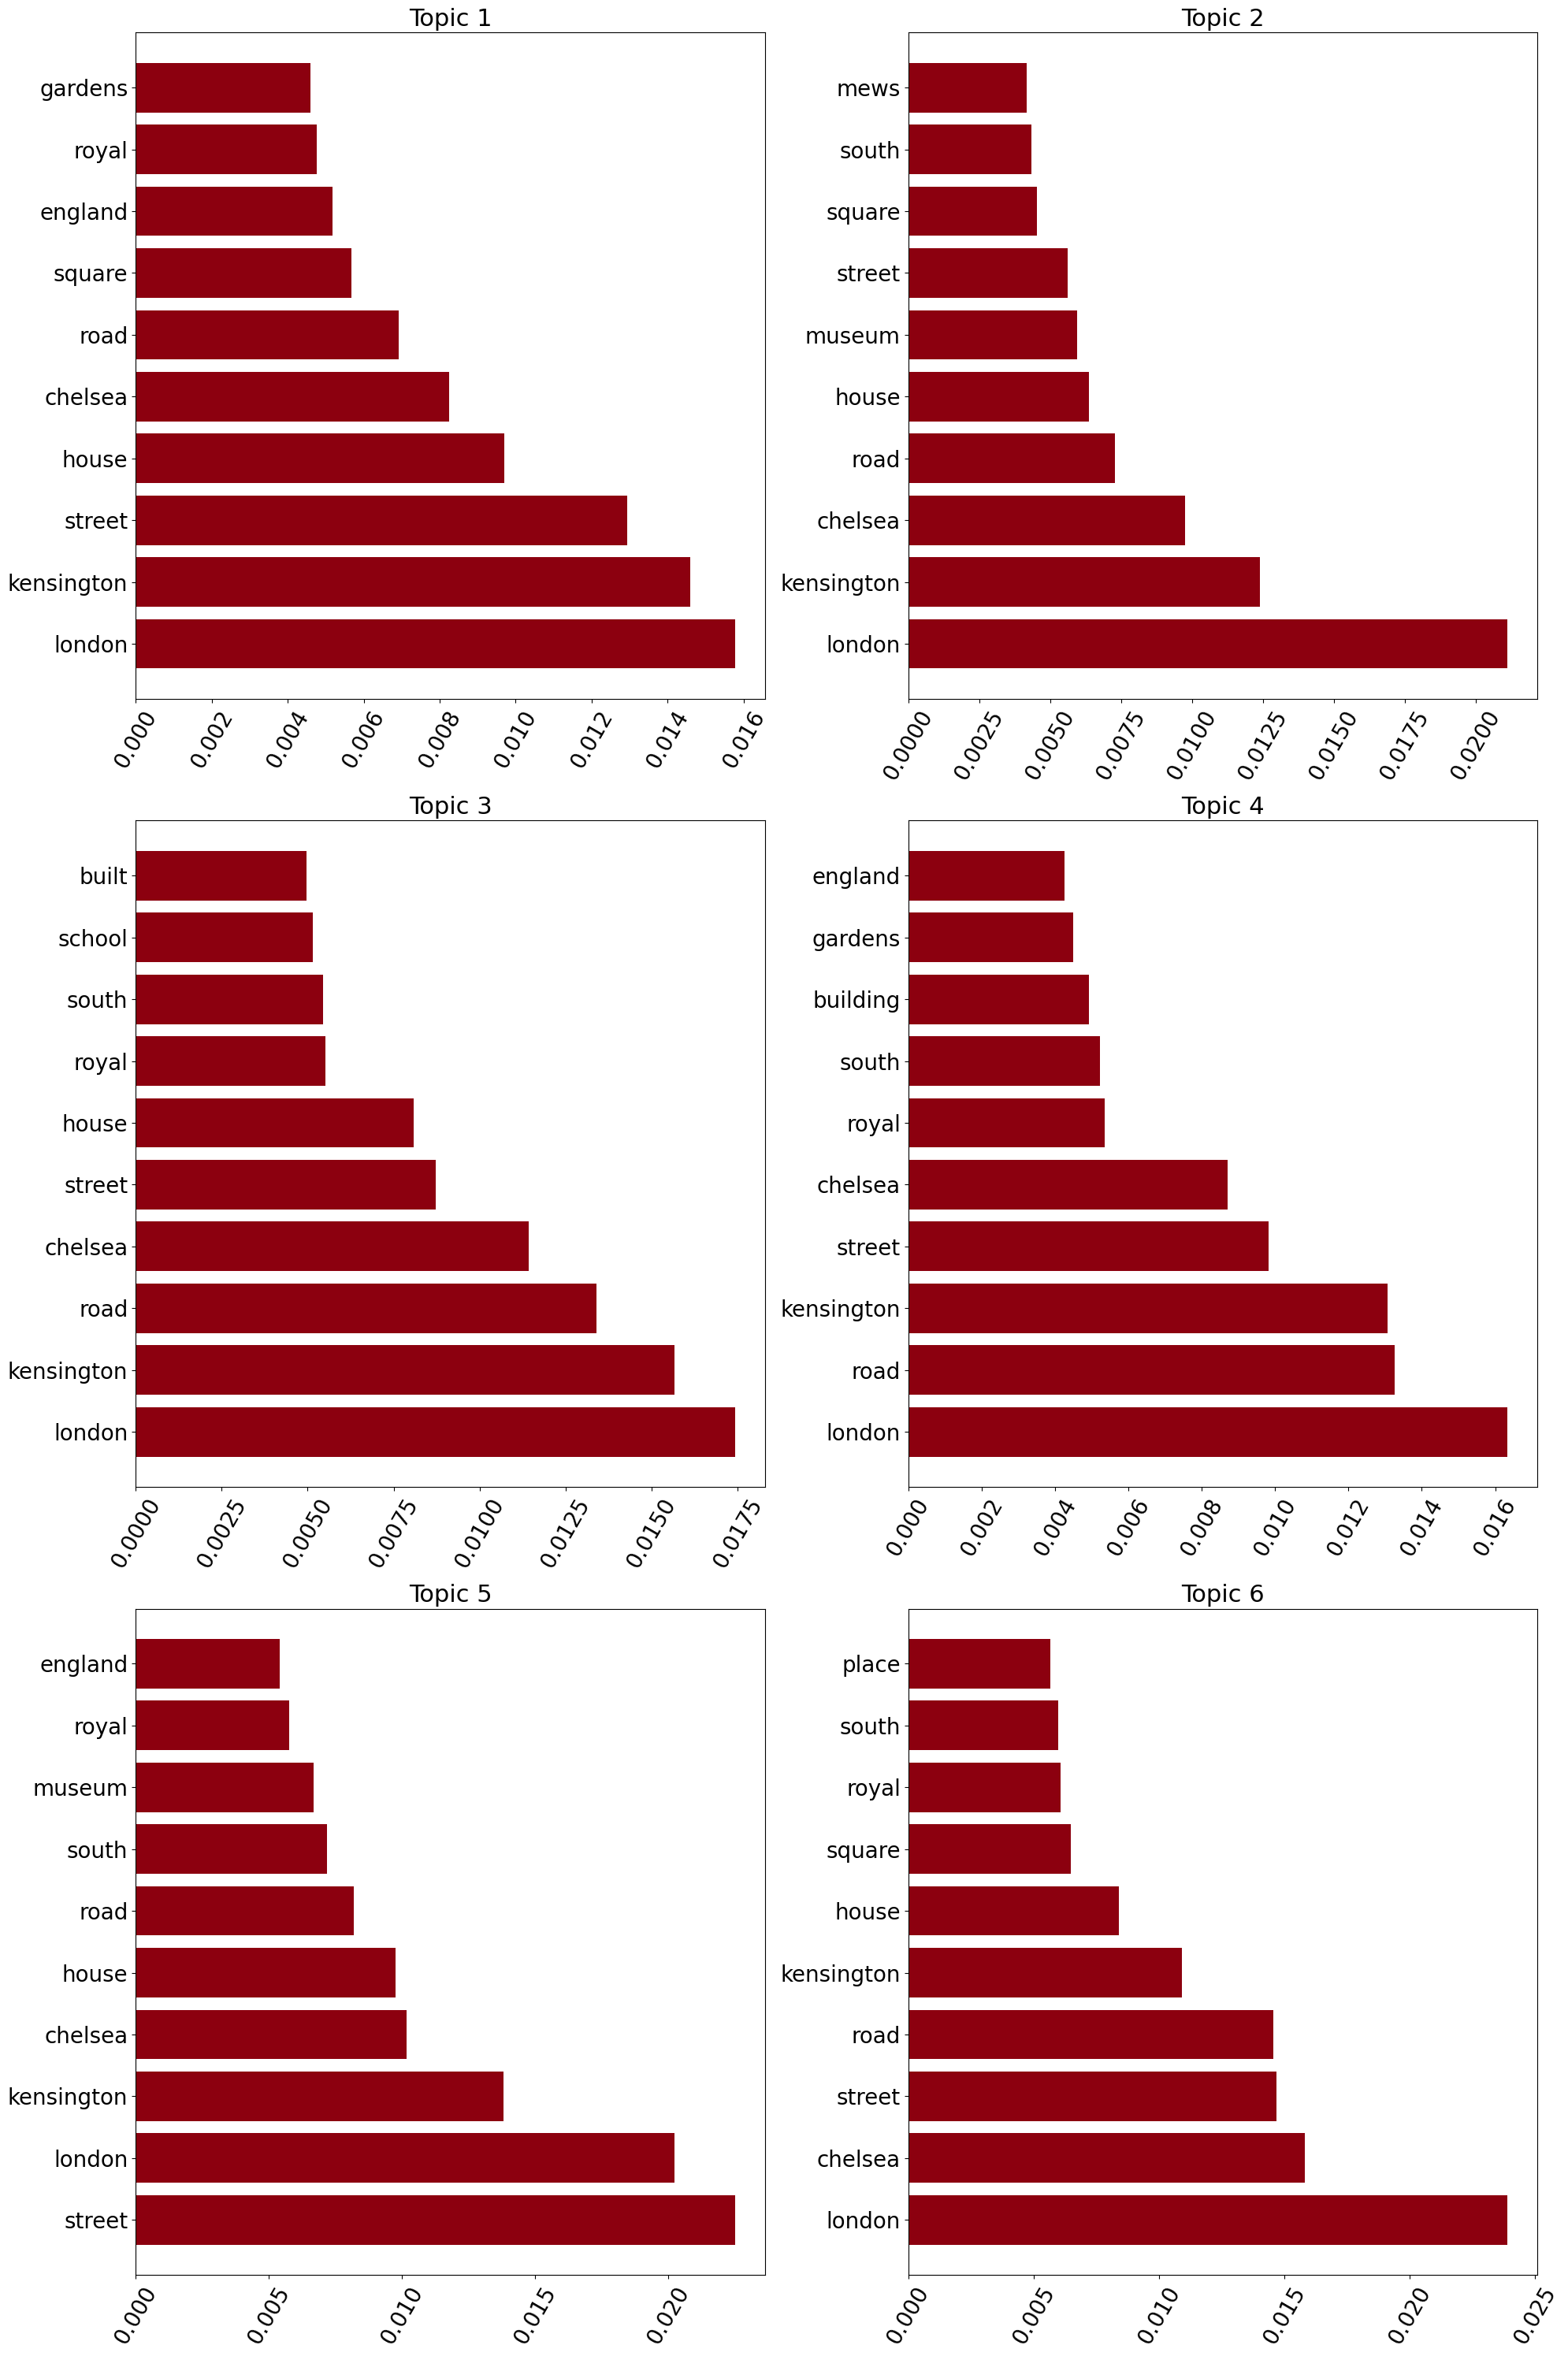

In [16]:
fig =plt.figure(figsize=(20,30))
fig_no = 0
for i in range(0,10):
    df=pd.DataFrame(lda_model_6topics.show_topic(i, topn = 10), 
                    columns=['term','probability'])
    plt.subplot(3,2,i+1)
    plt.title('Topic '+str(i+1), fontsize = 22)
    plt.barh(df['term'], df['probability'],
                 color = "#8C000F")
    plt.xlabel = 'Term'
    plt.ylabel = 'Probability'
    plt.xticks(rotation= 60, fontsize = 20)
    plt.yticks(fontsize=20)
    fig.tight_layout()
    fig_no += 1
    bar_plot = '../../docs/docs_agile/kc_wiki_lda' + str(fig_no) + '.png'
    plt.savefig(bar_plot)


plt.show()

In [20]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_6topics, 
                                     texts=tag_list_dbscan, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.3380074724851399

In [22]:
#Topic distribution for each dbscan cluster
all_topics = lda_model_6topics.get_document_topics(corpus)
num_docs = len(all_topics)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
colnames = ['Topic'+str(i+1) for i in range(0,6)]
all_topics_df = pd.DataFrame(all_topics_numpy, columns = colnames)
#find the dominant topic for each DBSCAN cluster
all_topics_df['Topic'] = all_topics_df[colnames].idxmax(axis=1)
all_topics_df

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic
0,0.0,0.327307,0.000000,0.669868,0.000000,0.000000,Topic4
1,0.0,0.000000,0.294456,0.000000,0.704864,0.000000,Topic5
2,0.0,0.000000,0.000000,0.000000,0.000000,0.999211,Topic6
3,0.0,0.000000,0.000000,0.000000,0.731568,0.263929,Topic5
4,0.0,0.000000,0.430456,0.000000,0.000000,0.568869,Topic6
5,0.0,0.000000,0.000000,0.000000,0.000000,0.997268,Topic6
6,0.0,0.000000,0.000000,0.000000,0.000000,0.994891,Topic6
7,0.0,0.000000,0.000000,0.000000,0.999113,0.000000,Topic5
8,0.0,0.000000,0.000000,0.000000,0.998577,0.000000,Topic5
9,0.0,0.000000,0.000000,0.000000,0.703735,0.294846,Topic5


In [23]:
##add c_h polygon coordinates
all_topics_df['geometry'] = c_h
#set index as column
all_topics_df['cluster'] = all_topics_df.index

In [24]:
#add topic labels
#Name the lda topics
def get_lda_topic_name(topic):
    if topic == 'Topic1':
        return 'Notable Streets, Royal Houses & Gardens '
    elif topic == 'Topic2':
        return 'Tourism'
    elif topic == 'Topic3':
        return 'Notable Streets, Royal Houses & Gardens'
    elif topic == 'Topic4':
        return 'Notable Streets, Royal Houses & Gardens'
    elif topic == 'Topic5':
        return 'Tourism'
    else:
        return 'Notable Streets, Royal Houses & Gardens'
all_topics_df['LDA_Topic_Wiki'] = all_topics_df['Topic'].apply(get_lda_topic_name)

In [25]:
all_topics_df

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic,geometry,cluster,LDA_Topic_Wiki
0,0.0,0.327307,0.000000,0.669868,0.000000,0.000000,Topic4,POLYGON ((527917.5412245964 178457.12307075015...,0,"Notable Streets, Royal Houses & Gardens"
1,0.0,0.000000,0.294456,0.000000,0.704864,0.000000,Topic5,POLYGON ((525709.4463781597 179359.01048738707...,1,Tourism
2,0.0,0.000000,0.000000,0.000000,0.000000,0.999211,Topic6,POLYGON ((527136.4236915577 178053.64613489783...,2,"Notable Streets, Royal Houses & Gardens"
3,0.0,0.000000,0.000000,0.000000,0.731568,0.263929,Topic5,POLYGON ((525222.1932550565 180437.45155022765...,3,Tourism
4,0.0,0.000000,0.430456,0.000000,0.000000,0.568869,Topic6,POLYGON ((526343.2883341972 178617.13931584923...,4,"Notable Streets, Royal Houses & Gardens"
5,0.0,0.000000,0.000000,0.000000,0.000000,0.997268,Topic6,POLYGON ((526573.2112958535 177766.98345025198...,5,"Notable Streets, Royal Houses & Gardens"
6,0.0,0.000000,0.000000,0.000000,0.000000,0.994891,Topic6,POLYGON ((527430.8824505011 178997.26901269646...,6,"Notable Streets, Royal Houses & Gardens"
7,0.0,0.000000,0.000000,0.000000,0.999113,0.000000,Topic5,POLYGON ((527272.5425948336 178785.44507304748...,7,Tourism
8,0.0,0.000000,0.000000,0.000000,0.998577,0.000000,Topic5,POLYGON ((527789.5395355109 178974.42007676582...,8,Tourism
9,0.0,0.000000,0.000000,0.000000,0.703735,0.294846,Topic5,"POLYGON ((526857.8636884243 177495.8913853076,...",9,Tourism


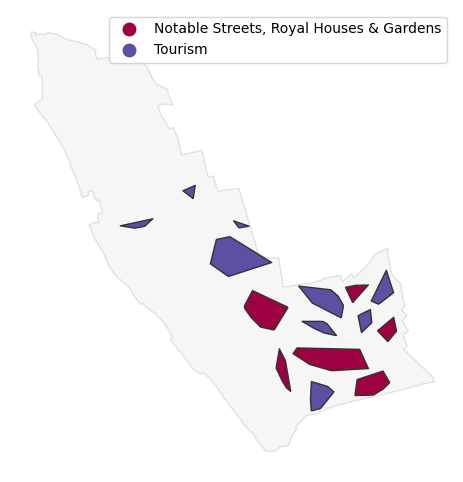

In [26]:
import geopandas as gpd
#Mapping
lda_cluster_gdf = gpd.GeoDataFrame(all_topics_df, geometry="geometry", crs='EPSG:27700')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=27700).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
lda_cluster_gdf.plot(column='LDA_Topic_Wiki', 
                      categorical = True  , 
                      edgecolor='0.2',
                      cmap='Spectral', 
                      ax=ax, 
                      legend = True
                      #legend_kwds={'label': "K-means Cluster", 'orientation': 'vertical'}
                     )
ax.set_axis_off()
map_k = '../../docs/docs_agile/kc_wiki_lda_map_agile.png'
plt.savefig(map_k)

In [29]:
#Bring BTM topic distribution run on R
##calling the saved  data from the folder
#load wiki data for Kc
kc_wiki_topic_df = pd.read_csv('../../docs/docs_agile/wiki_kc_btm.csv')

In [30]:
##add c_h polygon coordinates
kc_wiki_topic_df['geometry'] = c_h
#set index as column
kc_wiki_topic_df['cluster'] = kc_wiki_topic_df.index

In [32]:
#add topic labels
#Name the lda topics
def get_btm_topic_name(topic):
    if topic == 'V1':
        return 'Embassy'
    elif topic == 'V2':
        return 'Notable Roads and Streets'
    elif topic == 'V3':
        return 'Educational Institutes'
    elif topic == 'V4':
        return 'Diplomatic Mission, Museum & Arts'
    elif topic == 'V5':
        return 'Tourism'
    else:
        return 'House, Garden, Square'
kc_wiki_topic_df['BTM_topic_wiki'] = kc_wiki_topic_df['Topic'].apply(get_btm_topic_name)

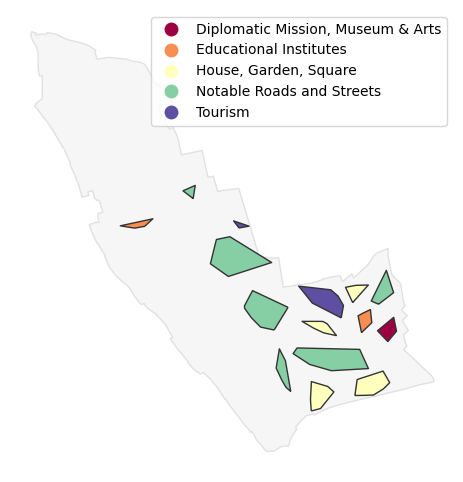

In [33]:
#Mapping
import geopandas as gpd
btm_cluster_gdf = gpd.GeoDataFrame(kc_wiki_topic_df, geometry="geometry", crs='EPSG:27700')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=27700).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
map = btm_cluster_gdf.plot(column='BTM_topic_wiki', 
                      categorical = True, 
                      edgecolor='0.2',
                      cmap='Spectral', 
                      ax=ax, 
                      legend = True) 
                    
                          
#map.legend(['BTM_topic_wiki'], loc='upper right')
ax.set_axis_off()
map_k = '../../docs/docs_agile/kc_wiki_btm_map.png'
plt.savefig(map_k)